# **Loading data**

In [1]:
# import time
import time
t1 = time.time()

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
train_data = pd.read_csv('../input/train.csv')

In [4]:
train_data.shape

(42000, 785)

In [5]:
train_data.head(10)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# **Feature Engineering**

In [6]:
features = train_data.columns.tolist()
output = "label"
features.remove(output)

In [7]:
train_X = train_data[features].as_matrix()
train_y = train_data[output].as_matrix()

In [8]:
train_y = train_y.astype(int)
train_y = pd.get_dummies(train_y).as_matrix()

In [9]:
train_X.shape

(42000, 784)

In [10]:
train_y.shape

(42000, 10)

# **Creating Convolutional Neural Network**

In [11]:
import tensorflow as tf
from tensorflow.python.framework import ops
ops.reset_default_graph()
# sess = tf.InteractiveSession()

In [12]:
# image dimensions
width = 28
height = 28
num_channels = 1
flat = width * height
num_classes = 10

In [13]:
x_image = tf.placeholder(tf.float32, shape=[None, flat])
image = tf.reshape(x_image, [-1, height, width, num_channels])
labels = tf.placeholder(tf.int32, shape=[None, num_classes])
keep_prob = tf.placeholder(tf.float32)

## **Create functions for creating deep learning layers¶**

In [14]:
def create_weights(shape):
    '''a function to create weight tensor'''
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))
 
def create_biases(size):
    '''a function to create bias tensor'''
    return tf.Variable(tf.constant(0.05, shape=[size]))

In [15]:
def create_convolutional_layer(input,
                               num_input_channels,
                               conv_filter_size,
                               max_pool_filter_size,
                               num_filters):  
    
    '''a function to create convoutional layer'''
    
    # create filter for the convolutional layer
    weights = create_weights(shape=[conv_filter_size, conv_filter_size, num_input_channels, num_filters])
    
    # create biases
    biases = create_biases(num_filters)
    
    # create covolutional layer
    layer = tf.nn.conv2d(input=input,
                     filter=weights,
                     strides=[1, 1, 1, 1],
                     padding='SAME')
    
    # add the bias to the convolutional layer
    layer += biases
    
    # relu activation layer fed into layer
    layer = tf.nn.relu(layer)
    
    # max pooling to half the size of the image
    layer = tf.nn.max_pool(value=layer,
                            ksize=[1, max_pool_filter_size, max_pool_filter_size, 1],
                            strides=[1, 2, 2, 1],
                            padding='SAME')
        
    # return the output layer of the convolution
    return layer

In [16]:
def create_flatten_layer(layer):
    
    '''a function for creating flattened layer from convolutional output'''
    
    # extract the shape of the layer
    layer_shape = layer.get_shape()
    # calculate the number features of the flattened layer
    num_features = layer_shape[1:4].num_elements()
    # create the flattened layer
    layer = tf.reshape(layer, [-1, num_features])
    # return the layer
    return layer

In [17]:
def create_fc_layer(input,          
                    num_inputs,    
                    num_outputs,
                    use_relu=True,
                    dropout = False, 
                    keep_prob = 0.2):
    
    '''a function for creating fully connected layer'''
    
    #Let's define trainable weights and biases.
    weights = create_weights(shape=[num_inputs, num_outputs])
    biases = create_biases(num_outputs)
    
    # matrix multiplication between input and weight matrix
    layer = tf.matmul(input, weights) + biases
    
    # add relu activation if wanted
    if use_relu:
        layer = tf.nn.relu(layer)
        
    # if dropout is wanted add dropout
    if dropout:        
        layer = tf.nn.dropout(layer, keep_prob)
    
    # return layer
    return layer

## **Create Layers of Covnet**

In [18]:
conv1_features = 64
conv1_filter_size = 5
max_pool_size1 = 2

conv2_features = 128
conv2_filter_size = 5
max_pool_size2 = 2

fc_layer_size1 = 1024
fc_layer_size2 = 512

In [19]:
layer_conv1 = create_convolutional_layer(input=image,
                                         num_input_channels= num_channels,
                                         conv_filter_size = conv1_filter_size,
                                         max_pool_filter_size = max_pool_size1,
                                         num_filters = conv1_features)
layer_conv1

<tf.Tensor 'MaxPool:0' shape=(?, 14, 14, 64) dtype=float32>

In [20]:
layer_conv2 = create_convolutional_layer(input=layer_conv1,
                                         num_input_channels= conv1_features,
                                         conv_filter_size = conv2_filter_size,
                                         max_pool_filter_size = max_pool_size2,
                                         num_filters = conv2_features)
layer_conv2

<tf.Tensor 'MaxPool_1:0' shape=(?, 7, 7, 128) dtype=float32>

In [21]:
layer_flat = create_flatten_layer(layer_conv2)
layer_flat

<tf.Tensor 'Reshape_1:0' shape=(?, 6272) dtype=float32>

In [22]:
layer_fc1 = create_fc_layer(input=layer_flat,
                            num_inputs=layer_flat.get_shape()[1:4].num_elements(),
                            num_outputs=fc_layer_size1,
                            use_relu=True,
                            dropout=False)
layer_fc1

<tf.Tensor 'Relu_2:0' shape=(?, 1024) dtype=float32>

In [23]:
layer_fc2 = create_fc_layer(input=layer_fc1,
                            num_inputs=fc_layer_size1,
                            num_outputs=fc_layer_size2,
                            use_relu=True,
                            dropout=True,
                            keep_prob=keep_prob)
layer_fc2

<tf.Tensor 'dropout/mul:0' shape=(?, 512) dtype=float32>

In [24]:
output_layer = create_fc_layer(input=layer_fc2,
                     num_inputs = fc_layer_size2,
                     num_outputs = num_classes,
                     use_relu=False)
output_layer

<tf.Tensor 'add_4:0' shape=(?, 10) dtype=float32>

## **Create prediction & accuracy metric**

In [25]:
y_pred = tf.nn.softmax(output_layer)
y_pred_cls = tf.argmax(y_pred, axis=1, output_type=tf.int32)
y_true_cls = tf.argmax(labels, axis=1, output_type=tf.int32)

In [26]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## **Create Optimizers**

In [27]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=output_layer,
                                                    labels=labels)
loss = tf.reduce_mean(cross_entropy)

In [28]:
learning_rate = 1e-4
train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

# **Train Model**

In [29]:
train_indices = np.random.choice(len(train_y), round(len(train_y)*0.7), replace=False)
validation_indices = np.array(list(set(range(len(train_y))) - set(train_indices)))

image_train = train_X[train_indices]
image_validation = train_X[validation_indices]

labels_train = train_y[train_indices]
labels_validation = train_y[validation_indices]

In [30]:
train_loss = []
valid_loss = []
valid_acc = []

train_batch_size = 500
validation_batch_size = 1000
max_iter = 700

In [31]:
rand_index_validation = np.random.choice(labels_validation.shape[0], size=validation_batch_size)
image_rand_validation = image_validation[rand_index_validation]    
labels_rand_validation = labels_validation[rand_index_validation]

In [32]:
iteration = 0

with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())

    # while 59 minutes have not elapsed (to finish before the kernel is killed)
    while (time.time()-t1) < 3540:
        
        # break if max iteration is reached
        if iteration >= max_iter:
            break

        rand_index_train = np.random.choice(labels_train.shape[0], size=train_batch_size)
        image_rand_train = image_train[rand_index_train]    
        labels_rand_train = labels_train[rand_index_train]

        feed_dict_batch =  {x_image: image_rand_train,
                            labels: labels_rand_train,
                            keep_prob: 0.7}
        
        feed_dict_train =  {x_image: image_rand_train,
                            labels: labels_rand_train,
                            keep_prob: 1.0}

        feed_dict_validation =  {x_image: image_rand_validation,
                                 labels: labels_rand_validation,
                                 keep_prob:1.0}

        sess.run(train_step, feed_dict=feed_dict_batch)

        temp_train_loss = loss.eval(session=sess, feed_dict=feed_dict_train)
        train_loss.append(temp_train_loss)

        temp_validation_loss = loss.eval(session=sess, feed_dict=feed_dict_validation)
        valid_loss.append(temp_validation_loss)

        temp_validation_accuracy = accuracy.eval(session=sess, feed_dict=feed_dict_validation)
        valid_acc.append(temp_validation_accuracy)    
            
        print("iterations:",iteration,
              ", train_loss:",temp_train_loss,
              ", valid_loss:", temp_validation_loss,
              ", valid_accuracy:", temp_validation_accuracy)
        
        iteration += 1

iterations: 0 , train_loss: 63.5913 , valid_loss: 66.2108 , valid_accuracy: 0.121
iterations: 1 , train_loss: 37.8256 , valid_loss: 46.9124 , valid_accuracy: 0.295
iterations: 2 , train_loss: 35.4026 , valid_loss: 43.5536 , valid_accuracy: 0.4
iterations: 3 , train_loss: 40.9258 , valid_loss: 43.2129 , valid_accuracy: 0.421
iterations: 4 , train_loss: 33.4833 , valid_loss: 34.2617 , valid_accuracy: 0.481
iterations: 5 , train_loss: 20.3957 , valid_loss: 21.0948 , valid_accuracy: 0.584
iterations: 6 , train_loss: 11.7143 , valid_loss: 13.9874 , valid_accuracy: 0.619
iterations: 7 , train_loss: 9.51382 , valid_loss: 9.30807 , valid_accuracy: 0.677
iterations: 8 , train_loss: 8.40814 , valid_loss: 7.41297 , valid_accuracy: 0.73
iterations: 9 , train_loss: 9.37361 , valid_loss: 8.69566 , valid_accuracy: 0.724
iterations: 10 , train_loss: 11.1464 , valid_loss: 10.1656 , valid_accuracy: 0.692
iterations: 11 , train_loss: 10.6801 , valid_loss: 9.24406 , valid_accuracy: 0.688
iterations: 12 , 

## **Visualize Performance**

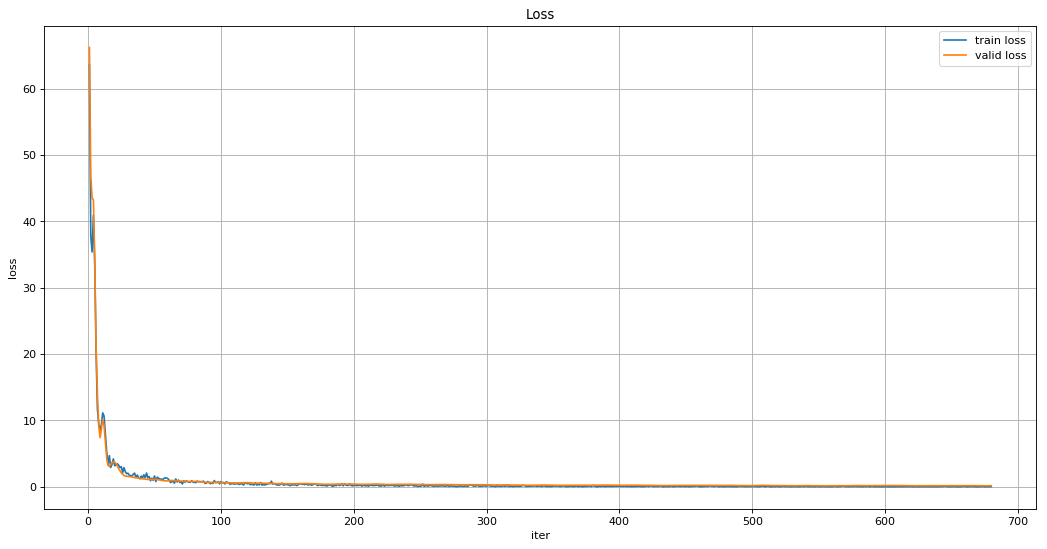

In [33]:
plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
iterations = list(range(1,iteration+1))
plt.plot(iterations, train_loss, label = "train loss")
plt.plot(iterations, valid_loss, label = "valid loss")
plt.title("Loss")
plt.xlabel("iter")
plt.ylabel("loss")
plt.legend()
plt.grid()
plt.show()

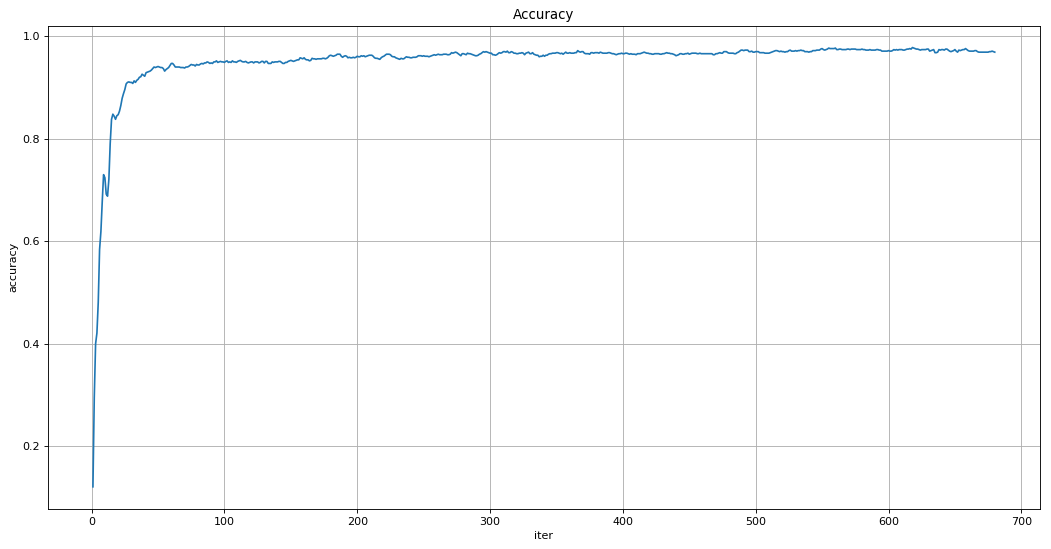

In [34]:
plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(iterations, valid_acc, label = "train loss")
plt.title("Accuracy")
plt.xlabel("iter")
plt.ylabel("accuracy")
plt.grid()
plt.show()